In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd

OPENCV_OBJECT_TRACKERS = {
    "csrt": cv2.legacy.TrackerCSRT_create(),
    "kcf": cv2.legacy.TrackerKCF_create(),
    "boosting": cv2.legacy.TrackerBoosting_create(),
    "mil": cv2.legacy.TrackerMIL_create(),
    "tld": cv2.legacy.TrackerTLD_create(),
    "medianflow": cv2.legacy.TrackerMedianFlow_create(),
    "mosse": cv2.legacy.TrackerMOSSE_create()
}
 #trackerlarin isimleri ve fonksiyonlari





Tracker : < cv2.legacy.TrackerBoosting 0000018EF4C42F70>
Tracking Method boosting
Time 37.003408432006836
Number of frame to track(gt) : 451
Number of frama to track (success) : 299
Toplam hata


C:\Users\umuty\AppData\Local\Temp\ipykernel_10648\1101610244.py:121: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(np.sqrt(gt_center_x-track_df_center_x)**2 + (gt_center_y-track_df_center_y)**2)
C:\Users\umuty\AppData\Local\Temp\ipykernel_10648\1101610244.py:125: RuntimeWarning: invalid value encountered in sqrt
  error = np.sum((np.sqrt(gt_center_x-track_df_center_x)**2 + (gt_center_y-track_df_center_y)**2))


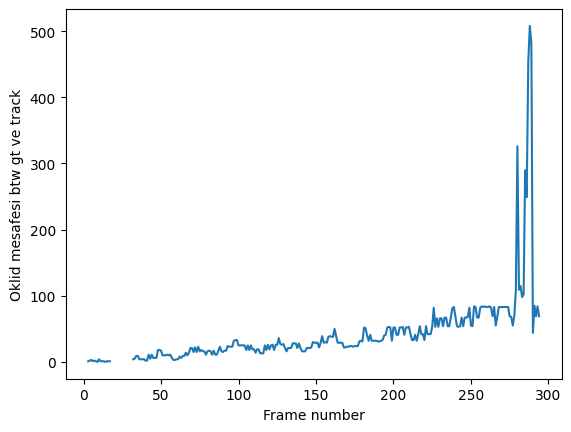

In [ ]:
tracker_name = "boosting" #degistirerek farkli trackerlar deneyebiliriz

tracker =cv2.legacy.TrackerBoosting_create()  #fonksiyon oldugu icin parantez koyuyoruz
print("Tracker :",tracker)

gt = pd.read_csv("gt_new.txt") #ground truth dosyasi okunuyor

video_path = "MOT17-13-SDP.mp4" #video dosyasi okunuyor

cap =cv2.VideoCapture(video_path)    #video okunuyor

#genel parametreler

initBB=None 
fps= 25 #frame per second
frame_number =[] #frame sayisi
f=0 
success_track_frame_success = 0 #basarili takip edilen frame sayisi
track_list = [] 
start_time = time.time()

while True:
    time.sleep(0.01) #her frame arasinda 1/fps kadar bekletme yapar
    ret, frame = cap.read() #frame okunuyor

    if ret :
        frame=cv2.resize(frame,(960,540)) #frame boyutu degistiriliyor

        (h,w)= frame.shape[:2] #frame boyutlari aliniyor

        car_gt = gt[gt.frame_no== f] #ground truth dosyasindan frame numarasi aliniyor
        
        if len(car_gt)!=0: #eger ground truth dosyasi bos degilse
            
            #print(car_gt)
            ##gt islemleri
            x=car_gt.x.values[0] #ground truth dosyasindan x degeri aliniyor
            y=car_gt.y.values[0]
            w=car_gt.w.values[0]
            h=car_gt.h.values[0]

            center_x = car_gt.center_x.values[0] #ground truth dosyasindan center x ve y degerleri aliniyor
            center_y = car_gt.center_y.values[0]

            cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),2) #ground truth degerlerine gore dikdortgen ciziliyor

            cv2.circle(frame,(center_x,center_y,),2,(0,0,255),2) #ground truth degerlerine gore merkez noktasi ciziliyor

        ##box islemleri

        # box
        if initBB is not None:
            
            (success, box) = tracker.update(frame) #tracker update ediliyor
            
            if f<=np.max(gt.frame_no): #eger takip ettigi nesne ekran dan cikarsa takip etmeyi birakir
                (x,y,w,h) = [int(i) for i in box]
                
                cv2.rectangle(frame, (x,y),(x+w,y+h),(0,0,255),2) #takip edilen nesneye dikdortgen ciziliyor
                success_track_frame_success = success_track_frame_success + 1 #basarili takip edilen frame sayisi arttiriliyor
                
                track_center_x = int(x+w/2)
                
                track_center_y = int(y+h/2) 
                
                track_list.append([f,track_center_x,track_center_y]) #takip edilen nesnenin merkez noktasi listeye ekleniyor
            
            info = [("Tracker",tracker_name), 
                    ("Success", "Yes" if success else "No")]
            
            for (i,(o,p)) in enumerate(info): #takip edilen nesnenin bilgileri yazdiriliyor
                text = "{}: {} ".format(o,p)
                cv2.putText(frame, text, (10, h -((i*20)-25)), cv2.FONT_HERSHEY_SIMPLEX,0.6, (0,0,255),2)
            
        cv2.putText(frame,"Frame Num: "+str(f), (10,30),cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255),2)
        cv2.imshow("frame",frame)    

        key = cv2.waitKey(1) &0xFF
        

        if key== ord("t"):

            initBB=cv2.selectROI("Frame",frame,fromCenter=False)
            tracker.init(frame,initBB)

        elif key == ord("q"): #eger s tusuna basilirsa
            break
        
        frame_number.append(f)
        f= f+1

    else:
        break

cap.release()
cv2.destroyAllWindows()


stop_time = time.time() #programin calisma suresi hesaplaniyor
time_diff = stop_time-start_time

#basari degerlendirme

track_df = pd.DataFrame(track_list,columns=["frame_no","center_x","center_y"]) #takip edilen nesnenin merkez noktasi dataframe e cevriliyor

if len(track_df)!=0: #eger takip edilen nesne varsa
    print("Tracking Method",tracker_name)   
    print("Time",time_diff)
    print("Number of frame to track(gt) :",len(gt))
    print("Number of frama to track (success) :",success_track_frame_success)

    track_df_frame= track_df.frame_no   #takip edilen nesnenin frame numarasi aliniyor

    gt_center_x= gt.center_x[track_df_frame].values #ground truth dosyasindan center x ve y degerleri aliniyor
    gt_center_y= gt.center_y[track_df_frame].values 


    track_df_center_x = track_df.center_x.values    #takip edilen nesnenin merkez noktasi aliniyor
    track_df_center_y = track_df.center_y.values

    plt.plot(np.sqrt(gt_center_x-track_df_center_x)**2 + (gt_center_y-track_df_center_y)**2)    #oklid mesafesi hesaplaniyor
    plt.xlabel("Frame number")
    plt.ylabel("Oklid mesafesi btw gt ve track")

    error = np.sum(np.sqrt((gt_center_x-track_df_center_x)**2 + (gt_center_y-track_df_center_y)**2))    #toplam hata hesaplaniyor

    print("Toplam hata",error)



